In [22]:
from gausspy_pipeline import GausspyPipeline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pickle
from astropy.io import fits

# 1. Create pipeline and initialize all parameters
pipeline = GausspyPipeline(
    cube_file='../datacubes/spw0.fits',
    v1=10, v2=1500, x1=190, x2=210, y1=220, y2=240,
    alpha1=0.1, alpha2=12.0, snr_thresh=3.0,
    stack_vrange=(-200, 200), stack_dv=0.2
)


In [23]:
# transform the fits cube to gausspy format
pipeline.prepare_input()

d = pickle.load(open('spectrum_for_gausspy.pickle', 'rb'))
print(d.keys())
print(len(d['x_values']), len(d['data_list']), len(d['errors']))
print(type(d['x_values'][0]), type(d['data_list'][0]), type(d['errors'][0]))
print(d['x_values'][0].shape, d['data_list'][0].shape, d['errors'][0].shape)

for i, spec in enumerate(d['data_list']):
    if np.any(np.isnan(spec)):
        print(f"Spectrum {i} 有 NaN！")
    elif np.any(np.isinf(spec)):
        print(f"Spectrum {i} 有 Inf！")
    elif np.all(spec == 0):
        print(f"Spectrum {i} 全部為 0！")
    elif len(spec) == 0:
        print(f"Spectrum {i} 長度為 0！")
    elif not np.issubdtype(spec.dtype, np.floating):
        print(f"Spectrum {i} 不是 float 類型！")


Prepared 400 spectra → spectrum_for_gausspy.pickle
dict_keys(['x_values', 'data_list', 'errors', 'location'])
400 400 400
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1490,) (1490,) (1490,)


In [24]:
#decomposition
pipeline.run_decomposition()

Running GaussPy phase-two decomposition ...
using 6 out of 8 cpus
   ---->   0


  0%|          | 0.00/399 [00:00<?, ?it/s]

   ---->     ---->     ---->     ---->       ---->       ---->  2143  



56



  0%|          | 1.00/399 [00:04<31:08, 4.69s/it]

   ---->   7


  1%|          | 2.00/399 [00:04<13:31, 2.04s/it]

   ---->   8
   ---->   9


  1%|          | 4.00/399 [00:05<05:25, 1.21it/s]

   ---->   10
   ---->   11
   ---->  

  2%|▏         | 6.00/399 [00:06<04:24, 1.48it/s]

 12


  2%|▏         | 7.00/399 [00:10<09:53, 1.51s/it]

   ---->   13


  2%|▏         | 8.00/399 [00:10<07:45, 1.19s/it]

   ---->   14
   ---->  

  2%|▏         | 9.00/399 [00:10<06:12, 1.05it/s]

 15


  3%|▎         | 10.0/399 [00:10<04:52, 1.33it/s]

   ---->   16


  3%|▎         | 11.0/399 [00:12<05:29, 1.18it/s]

   ---->   17


  3%|▎         | 12.0/399 [00:12<04:19, 1.49it/s]

   ---->   18
   ---->  

  3%|▎         | 13.0/399 [00:16<10:33, 1.64s/it]

 19
   ---->   20


  4%|▍         | 15.0/399 [00:16<06:00, 1.07it/s]

   ---->   21


  4%|▍         | 16.0/399 [00:16<04:48, 1.33it/s]

   ---->   22


  4%|▍         | 17.0/399 [00:17<04:43, 1.35it/s]

   ---->   23


  5%|▍         | 18.0/399 [00:17<04:29, 1.41it/s]

   ---->   24


  5%|▍         | 19.0/399 [00:22<10:55, 1.73s/it]

   ---->   25


  5%|▌         | 20.0/399 [00:23<10:03, 1.59s/it]

   ---->   26


  5%|▌         | 21.0/399 [00:23<07:40, 1.22s/it]

   ---->   27
   ---->   28
   ---->  

  6%|▌         | 23.0/399 [00:24<04:51, 1.29it/s]

 29


  6%|▌         | 24.0/399 [00:24<04:20, 1.44it/s]

   ---->   30
   ---->  

  6%|▋         | 25.0/399 [00:28<09:17, 1.49s/it]

 31
   ---->  

  7%|▋         | 26.0/399 [00:29<08:07, 1.31s/it]

 32
   ---->  

  7%|▋         | 27.0/399 [00:29<06:23, 1.03s/it]

 33


  7%|▋         | 28.0/399 [00:30<05:30, 1.12it/s]

   ---->   34
   ---->  

  7%|▋         | 29.0/399 [00:30<04:12, 1.46it/s]

 35


  8%|▊         | 30.0/399 [00:30<03:45, 1.63it/s]

   ---->   36


  8%|▊         | 31.0/399 [00:34<08:49, 1.44s/it]

   ---->   37


  8%|▊         | 32.0/399 [00:34<07:12, 1.18s/it]

   ---->   38
   ---->  

  8%|▊         | 33.0/399 [00:35<05:25, 1.12it/s]

 39


  9%|▊         | 34.0/399 [00:35<05:22, 1.13it/s]

   ---->   40


  9%|▉         | 35.0/399 [00:36<03:59, 1.52it/s]

   ---->   41


  9%|▉         | 36.0/399 [00:36<03:00, 2.01it/s]

   ---->   42


  9%|▉         | 37.0/399 [00:39<08:42, 1.44s/it]

   ---->   43


 10%|▉         | 38.0/399 [00:41<08:35, 1.43s/it]

   ---->   44
   ---->  

 10%|▉         | 39.0/399 [00:42<08:25, 1.40s/it]

 45


 10%|█         | 40.0/399 [00:44<09:56, 1.66s/it]

   ---->   46
   ---->   47
   ---->  

 11%|█         | 42.0/399 [00:44<05:31, 1.08it/s]

 48


 11%|█         | 43.0/399 [00:47<07:55, 1.34s/it]

   ---->   49


 11%|█         | 44.0/399 [00:50<10:14, 1.73s/it]

   ---->   50
   ---->  

 11%|█▏        | 45.0/399 [00:51<08:45, 1.48s/it]

 51
   ---->  

 12%|█▏        | 46.0/399 [00:52<07:45, 1.32s/it]

 52


 12%|█▏        | 47.0/399 [00:52<06:03, 1.03s/it]

   ---->   53


 12%|█▏        | 48.0/399 [00:53<06:25, 1.10s/it]

   ---->   54
   ---->  

 12%|█▏        | 49.0/399 [00:53<04:55, 1.18it/s]

 55


 13%|█▎        | 50.0/399 [00:56<07:48, 1.34s/it]

   ---->   56
   ---->  

 13%|█▎        | 51.0/399 [00:56<05:50, 1.01s/it]

 57


 13%|█▎        | 52.0/399 [00:57<05:39, 1.02it/s]

   ---->   58


 13%|█▎        | 53.0/399 [00:58<04:55, 1.17it/s]

   ---->   59


 14%|█▎        | 54.0/399 [00:59<05:13, 1.10it/s]

   ---->   60
   ---->  

 14%|█▍        | 55.0/399 [00:59<04:05, 1.40it/s]

 61
   ---->  

 14%|█▍        | 56.0/399 [01:02<07:56, 1.39s/it]

 62
   ---->  

 14%|█▍        | 57.0/399 [01:03<07:48, 1.37s/it]

 63
   ---->  

 15%|█▍        | 58.0/399 [01:06<09:49, 1.73s/it]

 64
   ---->   65
   ---->  

 15%|█▌        | 60.0/399 [01:06<05:40, 1.01s/it]

 66


 15%|█▌        | 61.0/399 [01:08<06:29, 1.15s/it]

   ---->   67


 16%|█▌        | 62.0/399 [01:09<06:15, 1.11s/it]

   ---->   68


 16%|█▌        | 63.0/399 [01:10<05:45, 1.03s/it]

   ---->   69


 16%|█▌        | 64.0/399 [01:13<09:21, 1.68s/it]

   ---->   70


 16%|█▋        | 65.0/399 [01:13<07:33, 1.36s/it]

   ---->   71


 17%|█▋        | 66.0/399 [01:14<06:56, 1.25s/it]

   ---->   72


 17%|█▋        | 67.0/399 [01:16<08:12, 1.48s/it]

   ---->   73


 17%|█▋        | 68.0/399 [01:17<06:04, 1.10s/it]

   ---->   74
   ---->  

 17%|█▋        | 69.0/399 [01:17<05:00, 1.10it/s]

 75


 18%|█▊        | 70.0/399 [01:20<07:41, 1.40s/it]

   ---->   76


 18%|█▊        | 71.0/399 [01:20<05:33, 1.02s/it]

   ---->   77


 18%|█▊        | 72.0/399 [01:21<05:30, 1.01s/it]

   ---->   78


 18%|█▊        | 73.0/399 [01:22<06:40, 1.23s/it]

   ---->   79


 19%|█▊        | 74.0/399 [01:23<05:11, 1.04it/s]

   ---->   80


 19%|█▉        | 75.0/399 [01:23<04:05, 1.32it/s]

   ---->   81


 19%|█▉        | 76.0/399 [01:25<06:29, 1.20s/it]

   ---->   82


 19%|█▉        | 77.0/399 [01:26<06:06, 1.14s/it]

   ---->   83


 20%|█▉        | 78.0/399 [01:29<08:44, 1.63s/it]

   ---->   84
   ---->   85


 20%|██        | 80.0/399 [01:29<04:48, 1.11it/s]

   ---->   86
   ---->  

 20%|██        | 81.0/399 [01:32<06:49, 1.29s/it]

 87


 21%|██        | 82.0/399 [01:32<05:16, 1.00it/s]

   ---->   88
   ---->  

 21%|██        | 83.0/399 [01:33<04:46, 1.10it/s]

 89


 21%|██        | 84.0/399 [01:35<07:22, 1.41s/it]

   ---->   90
   ---->  

 21%|██▏       | 85.0/399 [01:35<05:40, 1.08s/it]

 91
   ---->  

 22%|██▏       | 86.0/399 [01:36<05:02, 1.03it/s]

 92


 22%|██▏       | 87.0/399 [01:39<07:34, 1.46s/it]

   ---->   93
   ---->  

 22%|██▏       | 88.0/399 [01:39<05:31, 1.07s/it]

 94


 22%|██▏       | 89.0/399 [01:39<04:24, 1.17it/s]

   ---->   95


 23%|██▎       | 90.0/399 [01:41<06:01, 1.17s/it]

   ---->   96


 23%|██▎       | 91.0/399 [01:42<04:43, 1.09it/s]

   ---->   97
   ---->  

 23%|██▎       | 92.0/399 [01:42<03:58, 1.29it/s]

 98
   ---->  

 23%|██▎       | 93.0/399 [01:44<06:05, 1.19s/it]

 99


 24%|██▎       | 94.0/399 [01:44<04:27, 1.14it/s]

   ---->   100


 24%|██▍       | 95.0/399 [01:45<03:47, 1.34it/s]

   ---->   101


 24%|██▍       | 96.0/399 [01:46<05:02, 1.00it/s]

   ---->   102


 24%|██▍       | 97.0/399 [01:48<05:20, 1.06s/it]

   ---->   103
   ---->  

 25%|██▍       | 98.0/399 [01:49<06:04, 1.21s/it]

 104


 25%|██▍       | 99.0/399 [01:50<05:35, 1.12s/it]

   ---->   105


 25%|██▌       | 100/399 [01:51<05:32, 1.11s/it] 

   ---->   106
   ---->   107
   ---->  

 26%|██▌       | 102/399 [01:53<05:20, 1.08s/it]

 108


 26%|██▌       | 103/399 [01:55<06:21, 1.29s/it]

   ---->   109


 26%|██▌       | 104/399 [01:57<06:52, 1.40s/it]

   ---->   110


 26%|██▋       | 105/399 [01:57<05:38, 1.15s/it]

   ---->   111


 27%|██▋       | 106/399 [01:58<04:21, 1.12it/s]

   ---->   112


 27%|██▋       | 107/399 [01:58<03:43, 1.31it/s]

   ---->   113


 27%|██▋       | 108/399 [01:59<03:44, 1.29it/s]

   ---->   114


 27%|██▋       | 109/399 [02:01<05:08, 1.06s/it]

   ---->   115


 28%|██▊       | 110/399 [02:02<06:17, 1.31s/it]

   ---->   116


 28%|██▊       | 111/399 [02:03<04:44, 1.01it/s]

   ---->   117


 28%|██▊       | 112/399 [02:03<03:33, 1.34it/s]

   ---->   118
   ---->  

 28%|██▊       | 113/399 [02:03<02:59, 1.59it/s]

 119


 29%|██▊       | 114/399 [02:04<03:28, 1.37it/s]

   ---->   120


 29%|██▉       | 115/399 [02:06<04:37, 1.02it/s]

   ---->   121


 29%|██▉       | 116/399 [02:07<05:46, 1.23s/it]

   ---->   122


 29%|██▉       | 117/399 [02:08<05:22, 1.14s/it]

   ---->   123


 30%|██▉       | 118/399 [02:09<04:26, 1.05it/s]

   ---->   124
   ---->  

 30%|██▉       | 119/399 [02:09<03:35, 1.30it/s]

 125


 30%|███       | 120/399 [02:12<05:49, 1.25s/it]

   ---->   126


 30%|███       | 121/399 [02:13<06:13, 1.34s/it]

   ---->   127


 31%|███       | 122/399 [02:15<06:17, 1.36s/it]

   ---->   128


 31%|███       | 123/399 [02:16<06:04, 1.32s/it]

   ---->   129
   ---->  

 31%|███       | 124/399 [02:17<05:27, 1.19s/it]

 130


 31%|███▏      | 125/399 [02:17<04:04, 1.12it/s]

   ---->   131


 32%|███▏      | 126/399 [02:18<04:45, 1.05s/it]

   ---->   132


 32%|███▏      | 127/399 [02:19<04:52, 1.07s/it]

   ---->   133


 32%|███▏      | 128/399 [02:20<04:44, 1.05s/it]

   ---->   134


 32%|███▏      | 129/399 [02:21<03:58, 1.13it/s]

   ---->   135


 33%|███▎      | 130/399 [02:22<03:57, 1.13it/s]

   ---->   136
   ---->   137


 33%|███▎      | 132/399 [02:23<03:43, 1.20it/s]

   ---->   138
   ---->  

 33%|███▎      | 133/399 [02:25<04:08, 1.07it/s]

 139
   ---->  

 34%|███▎      | 134/399 [02:26<04:52, 1.11s/it]

 140


 34%|███▍      | 135/399 [02:27<04:31, 1.03s/it]

   ---->   141


 34%|███▍      | 136/399 [02:28<04:25, 1.01s/it]

   ---->   142
   ---->  

 34%|███▍      | 137/399 [02:28<03:27, 1.26it/s]

 143


 35%|███▍      | 138/399 [02:31<05:33, 1.28s/it]

   ---->   144


 35%|███▍      | 139/399 [02:32<05:36, 1.29s/it]

   ---->   145


 35%|███▌      | 140/399 [02:32<04:21, 1.01s/it]

   ---->   146
   ---->  

 35%|███▌      | 141/399 [02:34<04:44, 1.10s/it]

 147
   ---->   148


 36%|███▌      | 143/399 [02:35<03:24, 1.25it/s]

   ---->   149
   ---->  

 36%|███▌      | 144/399 [02:37<05:01, 1.18s/it]

 150


 36%|███▋      | 145/399 [02:38<04:30, 1.07s/it]

   ---->   151


 37%|███▋      | 146/399 [02:38<03:30, 1.20it/s]

   ---->   152


 37%|███▋      | 147/399 [02:39<03:37, 1.16it/s]

   ---->   153
   ---->   154


 37%|███▋      | 149/399 [02:39<02:35, 1.60it/s]

   ---->   155


 38%|███▊      | 150/399 [02:42<04:21, 1.05s/it]

   ---->   156


 38%|███▊      | 151/399 [02:42<03:45, 1.10it/s]

   ---->   157


 38%|███▊      | 152/399 [02:43<03:10, 1.30it/s]

   ---->   158
   ---->  

 38%|███▊      | 153/399 [02:44<03:36, 1.14it/s]

 159
   ---->  

 39%|███▊      | 154/399 [02:45<03:21, 1.22it/s]

 160
   ---->  

 39%|███▉      | 155/399 [02:46<03:37, 1.12it/s]

 161


 39%|███▉      | 156/399 [02:49<06:11, 1.53s/it]

   ---->   162


 39%|███▉      | 157/399 [02:50<05:49, 1.44s/it]

   ---->   163


 40%|███▉      | 158/399 [02:51<05:37, 1.40s/it]

   ---->   164
   ---->   165


 40%|████      | 160/399 [02:52<03:28, 1.15it/s]

   ---->   166
   ---->   167


 41%|████      | 162/399 [02:54<04:10, 1.06s/it]

   ---->   168


 41%|████      | 163/399 [02:56<04:27, 1.13s/it]

   ---->   169


 41%|████      | 164/399 [02:57<04:14, 1.08s/it]

   ---->   170
   ---->   171
   ---->  

 42%|████▏     | 166/399 [02:57<02:48, 1.39it/s]

 172


 42%|████▏     | 167/399 [02:58<02:30, 1.54it/s]

   ---->   173
   ---->  

 42%|████▏     | 168/399 [02:59<03:31, 1.09it/s]

 174
   ---->  

 42%|████▏     | 169/399 [03:01<03:55, 1.02s/it]

 175


 43%|████▎     | 170/399 [03:01<03:32, 1.08it/s]

   ---->   176
   ---->  

 43%|████▎     | 171/399 [03:01<02:42, 1.40it/s]

 177


 43%|████▎     | 172/399 [03:02<02:43, 1.39it/s]

   ---->   178


 43%|████▎     | 173/399 [03:03<03:02, 1.24it/s]

   ---->   179


 44%|████▎     | 174/399 [03:06<04:45, 1.27s/it]

   ---->   180


 44%|████▍     | 175/399 [03:07<05:20, 1.43s/it]

   ---->   181
   ---->  

 44%|████▍     | 176/399 [03:08<04:38, 1.25s/it]

 182
   ---->  

 44%|████▍     | 177/399 [03:11<06:41, 1.81s/it]

 183


 45%|████▍     | 178/399 [03:12<05:18, 1.44s/it]

   ---->   184


 45%|████▍     | 179/399 [03:13<04:30, 1.23s/it]

   ---->   185
   ---->  

 45%|████▌     | 180/399 [03:13<03:20, 1.09it/s]

 186


 45%|████▌     | 181/399 [03:15<04:27, 1.23s/it]

   ---->   187


 46%|████▌     | 182/399 [03:15<03:43, 1.03s/it]

   ---->   188


 46%|████▌     | 183/399 [03:18<05:04, 1.41s/it]

   ---->   189
   ---->  

 46%|████▌     | 184/399 [03:18<04:05, 1.14s/it]

 190
   ---->   191


 47%|████▋     | 186/399 [03:19<02:28, 1.43it/s]

   ---->   192


 47%|████▋     | 187/399 [03:20<03:20, 1.06it/s]

   ---->   193


 47%|████▋     | 188/399 [03:21<03:06, 1.13it/s]

   ---->   194


 47%|████▋     | 189/399 [03:24<04:57, 1.42s/it]

   ---->   195
   ---->  

 48%|████▊     | 190/399 [03:24<03:52, 1.11s/it]

 196


 48%|████▊     | 191/399 [03:24<02:54, 1.19it/s]

   ---->   197


 48%|████▊     | 192/399 [03:25<02:23, 1.44it/s]

   ---->   198


 48%|████▊     | 193/399 [03:26<03:31, 1.03s/it]

   ---->   199


 49%|████▊     | 194/399 [03:28<04:04, 1.19s/it]

   ---->   200


 49%|████▉     | 195/399 [03:32<06:30, 1.91s/it]

   ---->   201


 49%|████▉     | 196/399 [03:32<04:43, 1.40s/it]

   ---->   202


 49%|████▉     | 197/399 [03:33<04:45, 1.41s/it]

   ---->   203


 50%|████▉     | 198/399 [03:35<04:36, 1.37s/it]

   ---->   204


 50%|████▉     | 199/399 [03:35<03:20, 1.00s/it]

   ---->   205


 50%|█████     | 200/399 [03:38<05:52, 1.77s/it]

   ---->   206
   ---->  

 50%|█████     | 201/399 [03:40<05:27, 1.65s/it]

 207
   ---->  

 51%|█████     | 202/399 [03:40<04:17, 1.31s/it]

 208


 51%|█████     | 203/399 [03:41<03:47, 1.16s/it]

   ---->   209
   ---->   210


 51%|█████▏    | 205/399 [03:41<02:15, 1.43it/s]

   ---->   211


 52%|█████▏    | 206/399 [03:44<04:03, 1.26s/it]

   ---->   212


 52%|█████▏    | 207/399 [03:46<04:00, 1.25s/it]

   ---->   213
   ---->  

 52%|█████▏    | 208/399 [03:47<03:52, 1.22s/it]

 214


 52%|█████▏    | 209/399 [03:47<03:28, 1.10s/it]

   ---->   215
   ---->  

 53%|█████▎    | 210/399 [03:49<03:45, 1.19s/it]

 216


 53%|█████▎    | 211/399 [03:49<02:53, 1.08it/s]

   ---->   217


 53%|█████▎    | 212/399 [03:52<04:26, 1.42s/it]

   ---->   218


 53%|█████▎    | 213/399 [03:53<04:34, 1.48s/it]

   ---->   219


 54%|█████▎    | 214/399 [03:55<04:14, 1.38s/it]

   ---->   220


 54%|█████▍    | 215/399 [03:55<03:47, 1.23s/it]

   ---->   221


 54%|█████▍    | 216/399 [03:56<03:16, 1.07s/it]

   ---->   222


 54%|█████▍    | 217/399 [03:56<02:31, 1.20it/s]

   ---->   223


 55%|█████▍    | 218/399 [03:59<04:26, 1.47s/it]

   ---->   224


 55%|█████▍    | 219/399 [04:01<04:35, 1.53s/it]

   ---->   225
   ---->  

 55%|█████▌    | 220/399 [04:04<05:48, 1.95s/it]

 226
   ---->   227
   ---->  

 56%|█████▌    | 222/399 [04:04<03:14, 1.10s/it]

 228


 56%|█████▌    | 223/399 [04:05<02:44, 1.07it/s]

   ---->   229
   ---->  

 56%|█████▌    | 224/399 [04:07<03:30, 1.21s/it]

 230


 56%|█████▋    | 225/399 [04:08<03:22, 1.16s/it]

   ---->   231


 57%|█████▋    | 226/399 [04:11<04:50, 1.68s/it]

   ---->   232


 57%|█████▋    | 227/399 [04:11<03:32, 1.24s/it]

   ---->   233


 57%|█████▋    | 228/399 [04:11<02:56, 1.03s/it]

   ---->   234


 57%|█████▋    | 229/399 [04:12<02:37, 1.08it/s]

   ---->   235
   ---->  

 58%|█████▊    | 230/399 [04:15<04:10, 1.48s/it]

 236


 58%|█████▊    | 231/399 [04:17<04:52, 1.74s/it]

   ---->   237


 58%|█████▊    | 232/399 [04:18<03:53, 1.40s/it]

   ---->   238


 58%|█████▊    | 233/399 [04:19<03:52, 1.40s/it]

   ---->   239


 59%|█████▊    | 234/399 [04:19<02:58, 1.08s/it]

   ---->   240
   ---->  

 59%|█████▉    | 235/399 [04:20<02:18, 1.19it/s]

 241


 59%|█████▉    | 236/399 [04:22<03:26, 1.27s/it]

   ---->   242


 59%|█████▉    | 237/399 [04:24<03:44, 1.38s/it]

   ---->   243


 60%|█████▉    | 238/399 [04:25<03:28, 1.30s/it]

   ---->   244


 60%|█████▉    | 239/399 [04:27<03:56, 1.48s/it]

   ---->   245


 60%|██████    | 240/399 [04:28<03:29, 1.32s/it]

   ---->   246


 60%|██████    | 241/399 [04:28<02:44, 1.04s/it]

   ---->   247


 61%|██████    | 242/399 [04:30<03:44, 1.43s/it]

   ---->   248


 61%|██████    | 243/399 [04:32<03:32, 1.36s/it]

   ---->   249


 61%|██████    | 244/399 [04:32<02:55, 1.13s/it]

   ---->   250


 61%|██████▏   | 245/399 [04:34<03:36, 1.40s/it]

   ---->   251


 62%|██████▏   | 246/399 [04:36<03:43, 1.46s/it]

   ---->   252
   ---->   253


 62%|██████▏   | 248/399 [04:39<03:41, 1.47s/it]

   ---->   254


 62%|██████▏   | 249/399 [04:40<03:49, 1.53s/it]

   ---->   255


 63%|██████▎   | 250/399 [04:41<03:01, 1.22s/it]

   ---->   256


 63%|██████▎   | 251/399 [04:43<03:24, 1.38s/it]

   ---->   257
   ---->   258


 63%|██████▎   | 253/399 [04:43<02:02, 1.19it/s]

   ---->   259


 64%|██████▎   | 254/399 [04:47<03:50, 1.59s/it]

   ---->   260


 64%|██████▍   | 255/399 [04:48<03:24, 1.42s/it]

   ---->   261


 64%|██████▍   | 256/399 [04:48<02:42, 1.14s/it]

   ---->   262


 64%|██████▍   | 257/399 [04:49<02:47, 1.18s/it]

   ---->   263


 65%|██████▍   | 258/399 [04:50<02:23, 1.02s/it]

   ---->   264


 65%|██████▍   | 259/399 [04:51<02:27, 1.05s/it]

   ---->   265


 65%|██████▌   | 260/399 [04:54<03:42, 1.60s/it]

   ---->   266


 65%|██████▌   | 261/399 [04:56<03:51, 1.68s/it]

   ---->   267


 66%|██████▌   | 262/399 [04:56<02:47, 1.23s/it]

   ---->   268
   ---->  

 66%|██████▌   | 263/399 [04:57<02:45, 1.22s/it]

 269


 66%|██████▌   | 264/399 [04:58<02:22, 1.05s/it]

   ---->   270


 66%|██████▋   | 265/399 [04:59<02:34, 1.15s/it]

   ---->   271


 67%|██████▋   | 266/399 [05:02<03:35, 1.62s/it]

   ---->   272
   ---->  

 67%|██████▋   | 267/399 [05:04<03:56, 1.79s/it]

 273
   ---->   274


 67%|██████▋   | 269/399 [05:05<02:31, 1.17s/it]

   ---->   275


 68%|██████▊   | 270/399 [05:05<02:03, 1.05it/s]

   ---->   276
   ---->  

 68%|██████▊   | 271/399 [05:06<01:59, 1.07it/s]

 277


 68%|██████▊   | 272/399 [05:09<02:43, 1.29s/it]

   ---->   278


 68%|██████▊   | 273/399 [05:11<03:16, 1.56s/it]

   ---->   279


 69%|██████▊   | 274/399 [05:11<02:25, 1.17s/it]

   ---->   280


 69%|██████▉   | 275/399 [05:11<01:59, 1.04it/s]

   ---->   281
   ---->  

 69%|██████▉   | 276/399 [05:12<01:35, 1.29it/s]

 282
   ---->  

 69%|██████▉   | 277/399 [05:13<02:03, 1.01s/it]

 283


 70%|██████▉   | 278/399 [05:17<03:26, 1.70s/it]

   ---->   284


 70%|██████▉   | 279/399 [05:20<04:21, 2.18s/it]

   ---->   285


 70%|███████   | 280/399 [05:20<03:13, 1.63s/it]

   ---->   286


 70%|███████   | 281/399 [05:21<02:20, 1.19s/it]

   ---->   287


 71%|███████   | 282/399 [05:21<01:47, 1.09it/s]

   ---->   288


 71%|███████   | 283/399 [05:22<01:40, 1.15it/s]

   ---->   289


 71%|███████   | 284/399 [05:26<03:28, 1.81s/it]

   ---->   290


 71%|███████▏  | 285/399 [05:28<03:47, 1.99s/it]

   ---->   291
   ---->  

 72%|███████▏  | 286/399 [05:28<02:53, 1.53s/it]

 292


 72%|███████▏  | 287/399 [05:29<02:04, 1.11s/it]

   ---->   293
   ---->  

 72%|███████▏  | 288/399 [05:29<01:30, 1.23it/s]

 294


 72%|███████▏  | 289/399 [05:29<01:07, 1.62it/s]

   ---->   295


 73%|███████▎  | 290/399 [05:33<03:00, 1.66s/it]

   ---->   296


 73%|███████▎  | 291/399 [05:35<03:12, 1.78s/it]

   ---->   297
   ---->   298


 73%|███████▎  | 293/399 [05:35<01:46, 1.01s/it]

   ---->   299
   ---->   300
   ---->  

 74%|███████▍  | 295/399 [05:35<01:05, 1.59it/s]

 301


 74%|███████▍  | 296/399 [05:39<02:24, 1.40s/it]

   ---->   302


 74%|███████▍  | 297/399 [05:43<03:06, 1.83s/it]

   ---->   303


 75%|███████▍  | 298/399 [05:43<02:21, 1.40s/it]

   ---->   304
   ---->   305


 75%|███████▌  | 300/399 [05:43<01:29, 1.10it/s]

   ---->   306


 75%|███████▌  | 301/399 [05:44<01:15, 1.30it/s]

   ---->   307
   ---->  

 76%|███████▌  | 302/399 [05:48<02:31, 1.57s/it]

 308


 76%|███████▌  | 303/399 [05:50<02:56, 1.84s/it]

   ---->   309


 76%|███████▌  | 304/399 [05:51<02:18, 1.45s/it]

   ---->   310
   ---->   311
   ---->  

 77%|███████▋  | 306/399 [05:51<01:27, 1.07it/s]

 312
   ---->  

 77%|███████▋  | 307/399 [05:52<01:20, 1.14it/s]

 313


 77%|███████▋  | 308/399 [05:55<02:11, 1.45s/it]

   ---->   314
   ---->  

 77%|███████▋  | 309/399 [05:57<02:24, 1.60s/it]

 315
   ---->  

 78%|███████▊  | 310/399 [05:57<01:55, 1.30s/it]

 316
   ---->   317
   ---->  

 78%|███████▊  | 312/399 [05:58<01:08, 1.26it/s]

 318


 78%|███████▊  | 313/399 [05:59<01:08, 1.25it/s]

   ---->   319


 79%|███████▊  | 314/399 [06:01<01:50, 1.30s/it]

   ---->   320


 79%|███████▉  | 315/399 [06:03<02:04, 1.48s/it]

   ---->   321
   ---->  

 79%|███████▉  | 316/399 [06:04<01:43, 1.25s/it]

 322


 79%|███████▉  | 317/399 [06:05<01:32, 1.12s/it]

   ---->   323
   ---->  

 80%|███████▉  | 318/399 [06:06<01:28, 1.10s/it]

 324


 80%|███████▉  | 319/399 [06:07<01:21, 1.02s/it]

   ---->   325


 80%|████████  | 320/399 [06:10<02:21, 1.79s/it]

   ---->   326


 80%|████████  | 321/399 [06:11<01:58, 1.52s/it]

   ---->   327


 81%|████████  | 322/399 [06:12<01:32, 1.21s/it]

   ---->   328


 81%|████████  | 323/399 [06:12<01:11, 1.06it/s]

   ---->   329


 81%|████████  | 324/399 [06:13<01:17, 1.04s/it]

   ---->   330


 81%|████████▏ | 325/399 [06:14<01:21, 1.10s/it]

   ---->   331


 82%|████████▏ | 326/399 [06:18<02:12, 1.81s/it]

   ---->   332


 82%|████████▏ | 327/399 [06:18<01:38, 1.37s/it]

   ---->   333


 82%|████████▏ | 328/399 [06:20<01:34, 1.34s/it]

   ---->   334


 82%|████████▏ | 329/399 [06:20<01:10, 1.01s/it]

   ---->   335
   ---->  

 83%|████████▎ | 330/399 [06:20<00:52, 1.32it/s]

 336


 83%|████████▎ | 331/399 [06:21<01:07, 1.01it/s]

   ---->   337
   ---->  

 83%|████████▎ | 332/399 [06:25<01:55, 1.73s/it]

 338


 83%|████████▎ | 333/399 [06:25<01:24, 1.28s/it]

   ---->   339
   ---->  

 84%|████████▎ | 334/399 [06:26<01:22, 1.27s/it]

 340


 84%|████████▍ | 335/399 [06:27<00:59, 1.07it/s]

   ---->   341


 84%|████████▍ | 336/399 [06:27<00:46, 1.36it/s]

   ---->   342


 84%|████████▍ | 337/399 [06:29<01:19, 1.29s/it]

   ---->   343


 85%|████████▍ | 338/399 [06:32<01:50, 1.81s/it]

   ---->   344


 85%|████████▍ | 339/399 [06:33<01:35, 1.59s/it]

   ---->   345


 85%|████████▌ | 340/399 [06:34<01:15, 1.28s/it]

   ---->   346


 85%|████████▌ | 341/399 [06:34<00:57, 1.01it/s]

   ---->   347


 86%|████████▌ | 342/399 [06:36<01:03, 1.12s/it]

   ---->   348


 86%|████████▌ | 343/399 [06:36<00:52, 1.07it/s]

   ---->   349


 86%|████████▌ | 344/399 [06:39<01:26, 1.57s/it]

   ---->   350
   ---->  

 86%|████████▋ | 345/399 [06:41<01:19, 1.48s/it]

 351


 87%|████████▋ | 346/399 [06:41<01:05, 1.24s/it]

   ---->   352


 87%|████████▋ | 347/399 [06:42<00:52, 1.00s/it]

   ---->   353


 87%|████████▋ | 348/399 [06:43<00:51, 1.00s/it]

   ---->   354


 87%|████████▋ | 349/399 [06:43<00:37, 1.33it/s]

   ---->   355


 88%|████████▊ | 350/399 [06:47<01:20, 1.65s/it]

   ---->   356


 88%|████████▊ | 351/399 [06:48<01:16, 1.58s/it]

   ---->   357
   ---->   358
   ---->  

 88%|████████▊ | 353/399 [06:48<00:43, 1.07it/s]

 359


 89%|████████▊ | 354/399 [06:50<00:46, 1.03s/it]

   ---->   360


 89%|████████▉ | 355/399 [06:50<00:36, 1.19it/s]

   ---->   361


 89%|████████▉ | 356/399 [06:53<01:05, 1.51s/it]

   ---->   362


 89%|████████▉ | 357/399 [06:55<01:09, 1.66s/it]

   ---->   363


 90%|████████▉ | 358/399 [06:56<00:52, 1.28s/it]

   ---->   364


 90%|████████▉ | 359/399 [06:57<00:47, 1.19s/it]

   ---->   365


 90%|█████████ | 360/399 [06:57<00:41, 1.07s/it]

   ---->   366


 90%|█████████ | 361/399 [06:58<00:33, 1.15it/s]

   ---->   367


 91%|█████████ | 362/399 [07:01<00:58, 1.59s/it]

   ---->   368


 91%|█████████ | 363/399 [07:03<01:01, 1.70s/it]

   ---->   369
   ---->  

 91%|█████████ | 364/399 [07:03<00:43, 1.25s/it]

 370


 91%|█████████▏| 365/399 [07:04<00:36, 1.07s/it]

   ---->   371


 92%|█████████▏| 366/399 [07:04<00:28, 1.17it/s]

   ---->   372


 92%|█████████▏| 367/399 [07:05<00:24, 1.29it/s]

   ---->   373


 92%|█████████▏| 368/399 [07:08<00:49, 1.61s/it]

   ---->   374


 92%|█████████▏| 369/399 [07:11<00:56, 1.89s/it]

   ---->   375
   ---->  

 93%|█████████▎| 370/399 [07:12<00:44, 1.55s/it]

 376


 93%|█████████▎| 371/399 [07:12<00:33, 1.20s/it]

   ---->   377


 93%|█████████▎| 372/399 [07:12<00:24, 1.09it/s]

   ---->   378


 93%|█████████▎| 373/399 [07:13<00:19, 1.35it/s]

   ---->   379


 94%|█████████▎| 374/399 [07:17<00:43, 1.74s/it]

   ---->   380
   ---->  

 94%|█████████▍| 375/399 [07:20<00:50, 2.09s/it]

 381
   ---->   382


 94%|█████████▍| 377/399 [07:20<00:26, 1.19s/it]

   ---->   383


 95%|█████████▍| 378/399 [07:20<00:20, 1.01it/s]

   ---->   384


 95%|█████████▍| 379/399 [07:21<00:16, 1.19it/s]

   ---->   385


 95%|█████████▌| 380/399 [07:26<00:37, 1.95s/it]

   ---->   386


 95%|█████████▌| 381/399 [07:28<00:36, 2.01s/it]

   ---->   387
   ---->   388


 96%|█████████▌| 383/399 [07:28<00:19, 1.24s/it]

   ---->   389


 96%|█████████▌| 384/399 [07:29<00:14, 1.03it/s]

   ---->   390
   ---->  

 96%|█████████▋| 385/399 [07:29<00:10, 1.28it/s]

 391


 97%|█████████▋| 386/399 [07:33<00:20, 1.59s/it]

   ---->   392


 97%|█████████▋| 387/399 [07:35<00:21, 1.76s/it]

   ---->   393


 97%|█████████▋| 388/399 [07:35<00:15, 1.44s/it]

   ---->   394


 97%|█████████▋| 389/399 [07:38<00:16, 1.68s/it]

   ---->   395


 98%|█████████▊| 390/399 [07:39<00:12, 1.44s/it]

   ---->   396


 98%|█████████▊| 391/399 [07:41<00:13, 1.63s/it]

   ---->   397


 98%|█████████▊| 392/399 [07:42<00:10, 1.53s/it]

   ---->   398


 98%|█████████▊| 393/399 [07:45<00:11, 1.86s/it]

   ---->   399


100%|██████████| 399/399 [07:50<00:00, 1.18s/it]
399it [00:00, 817950.78it/s]

SUCCESS
100 finished.%
GaussPy decomposition finished → gausspy_result.pickle
Result keys: ['index_fit', 'amplitudes_fit', 'fwhms_fit', 'means_fit', 'index_initial', 'amplitudes_initial', 'fwhms_initial', 'means_initial', 'amplitudes_fit_err', 'fwhms_fit_err', 'means_fit_err', 'best_fit_rchi2', 'amplitudes_fit_em', 'fwhms_fit_em', 'means_fit_em', 'means_fit_err_em', 'amplitudes_fit_err_em', 'fwhms_fit_err_em', 'fit_labels']


In [25]:
#show the results
pipeline.count_fits()

Total: 400, Success: 375, Failed: 25
Success rate: 93.8%


[0,
 1,
 2,
 3,
 4,
 5,
 20,
 21,
 22,
 23,
 40,
 41,
 42,
 43,
 60,
 61,
 62,
 80,
 81,
 82,
 100,
 101,
 102,
 179,
 219]

In [26]:
import pickle
with open('gausspy_result.pickle', 'rb') as f:
    result = pickle.load(f)
print(result.keys())

dict_keys(['index_fit', 'amplitudes_fit', 'fwhms_fit', 'means_fit', 'index_initial', 'amplitudes_initial', 'fwhms_initial', 'means_initial', 'amplitudes_fit_err', 'fwhms_fit_err', 'means_fit_err', 'best_fit_rchi2', 'amplitudes_fit_em', 'fwhms_fit_em', 'means_fit_em', 'means_fit_err_em', 'amplitudes_fit_err_em', 'fwhms_fit_err_em', 'fit_labels'])


In [27]:
fit_result_dic = pipeline.classify_fit_results('fit_result_dic.pickle')

已儲存 fit 結果分類於 fit_result_dic.pickle


In [28]:
import pickle
with open('fit_result_dic.pickle', 'rb') as f:
    result = pickle.load(f)

print(result.keys())  # 應該會看到 dict_keys(['s', 'm', 'f'])

print(f"單峰（s）數量: {len(result['s'])}")
print(f"多峰（m）數量: {len(result['m'])}")
print(f"擬合失敗（f）數量: {len(result['f'])}")


dict_keys(['s', 'm', 'f'])
單峰（s）數量: 295
多峰（m）數量: 80
擬合失敗（f）數量: 25


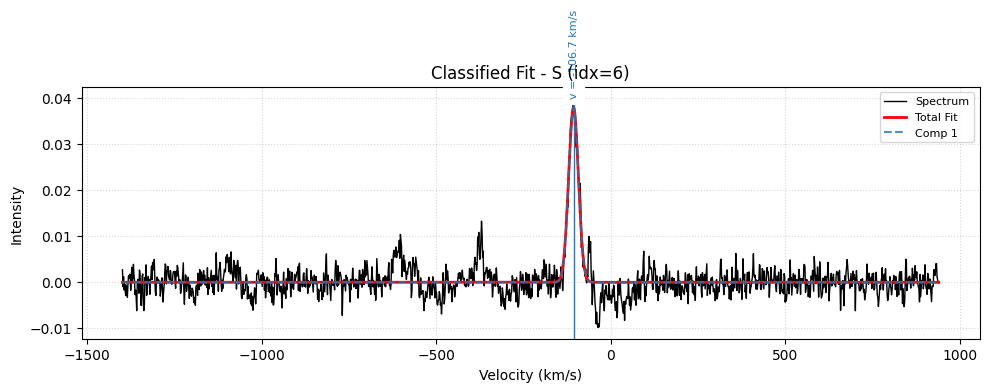

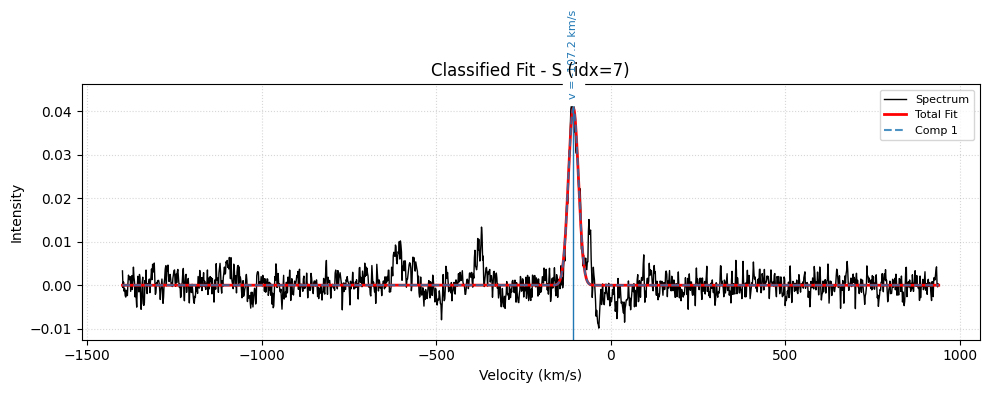

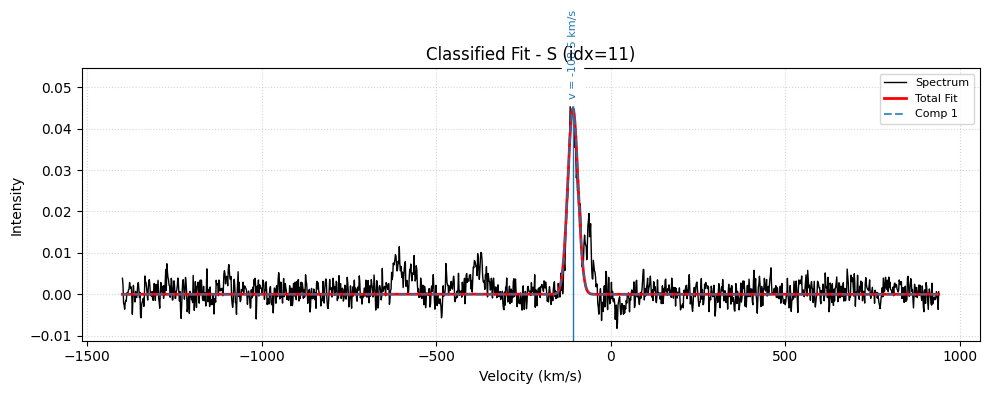

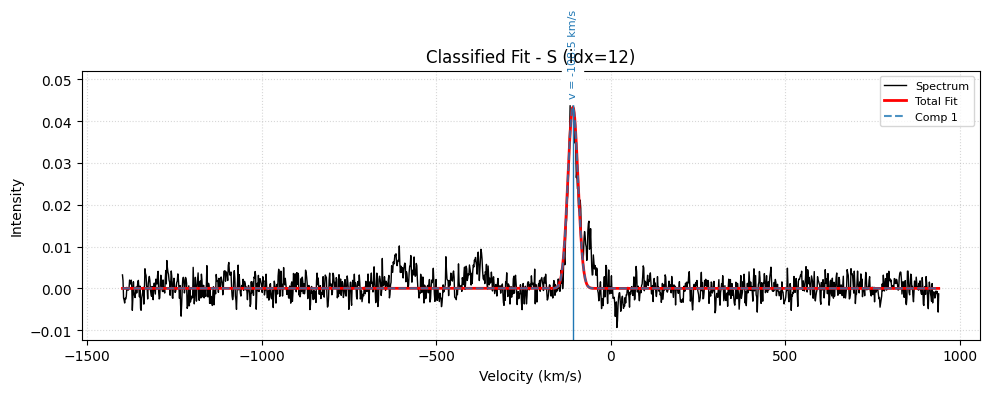

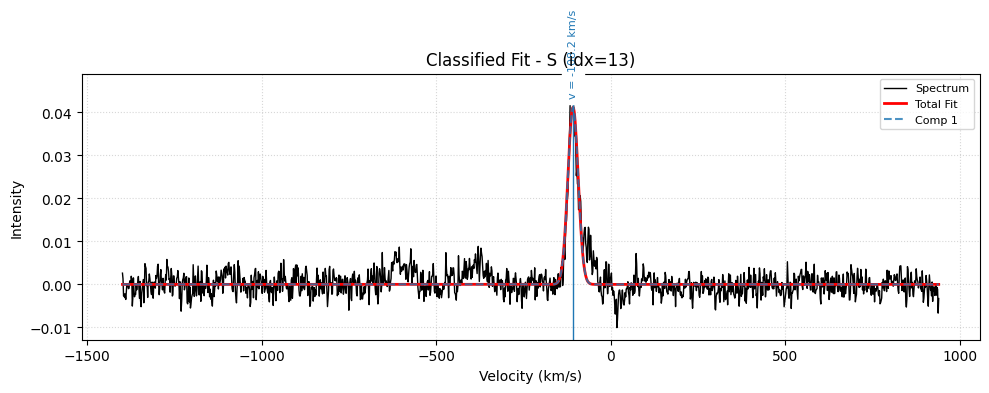

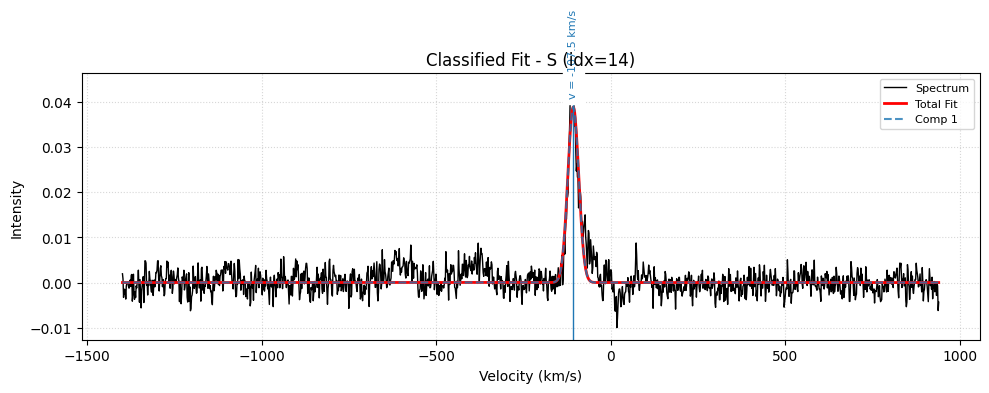

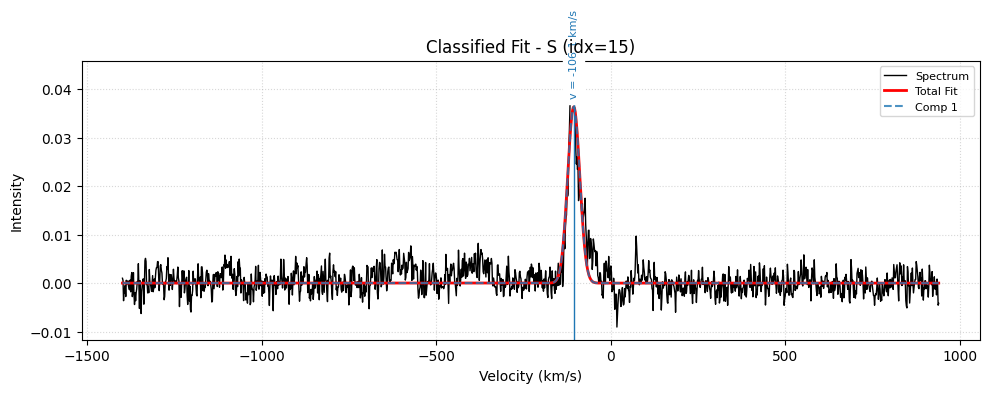

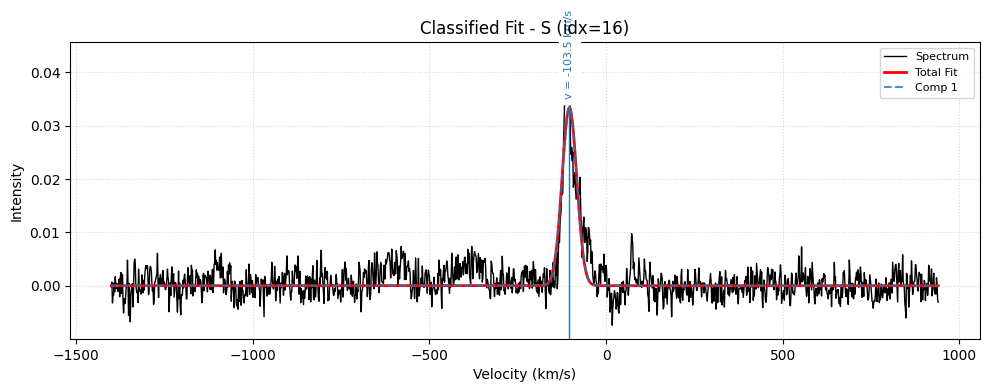

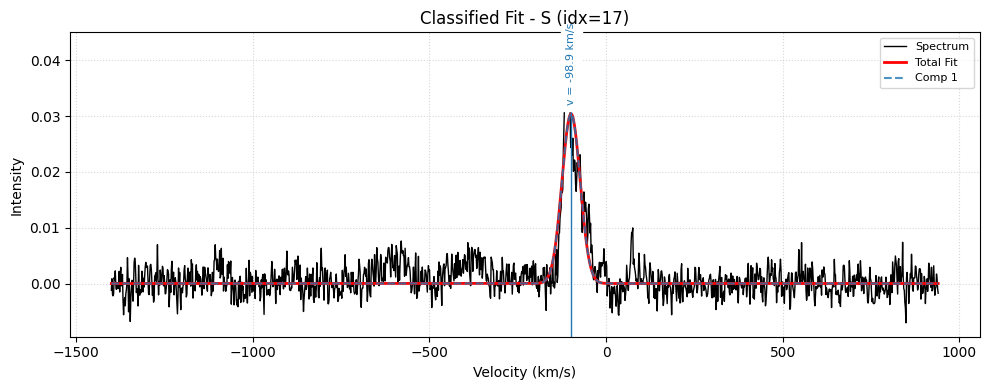

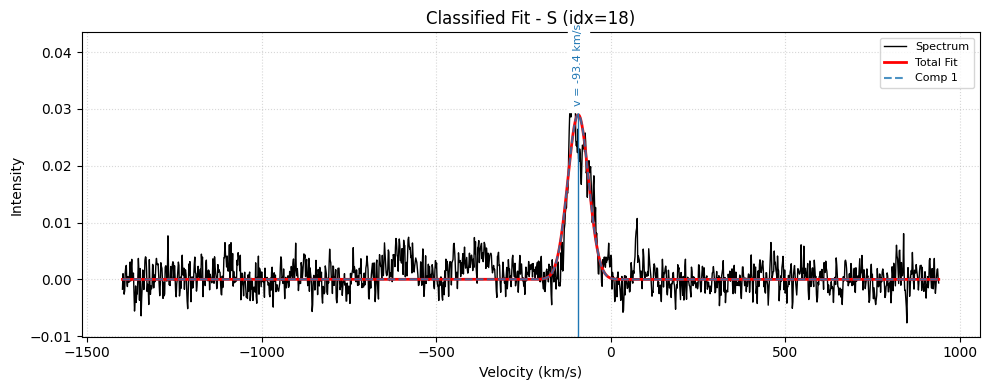

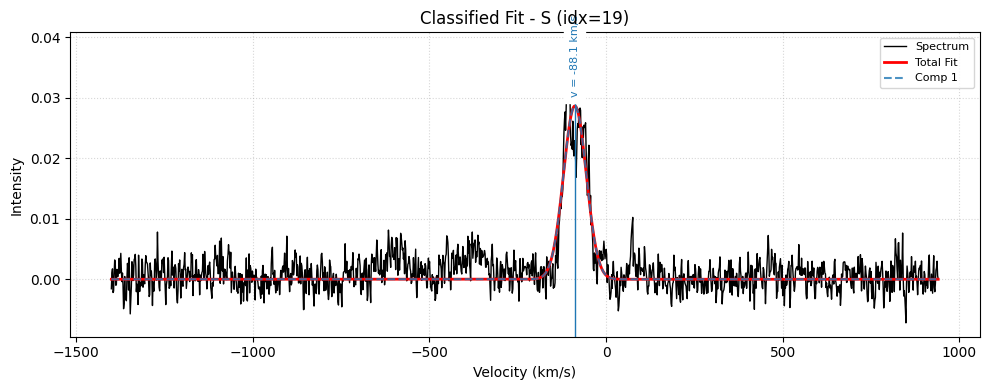

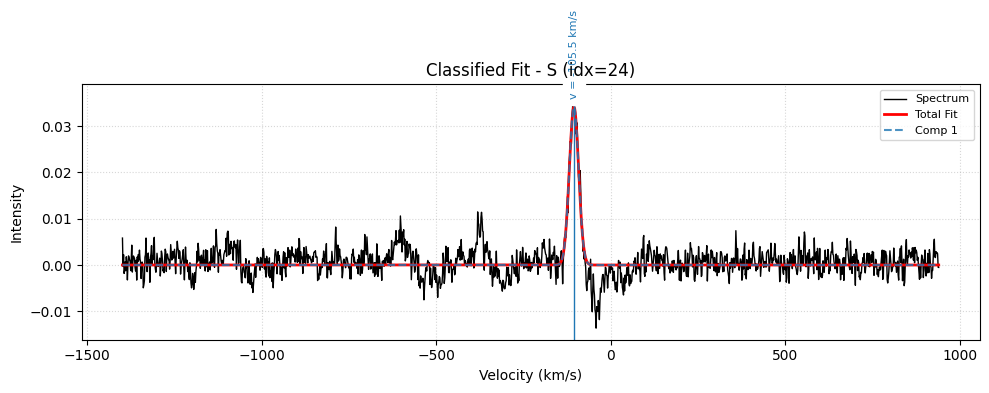

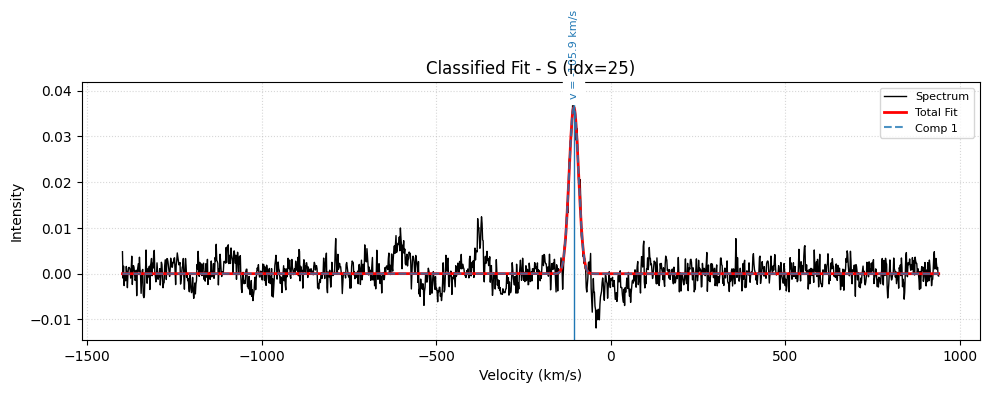

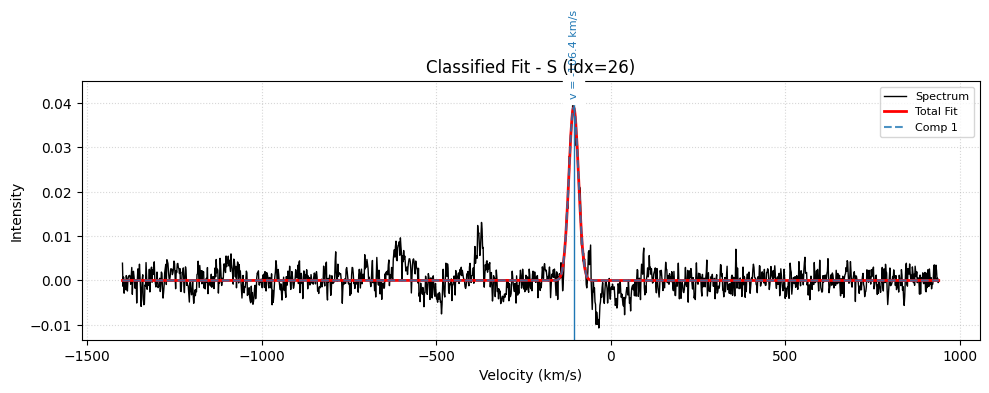

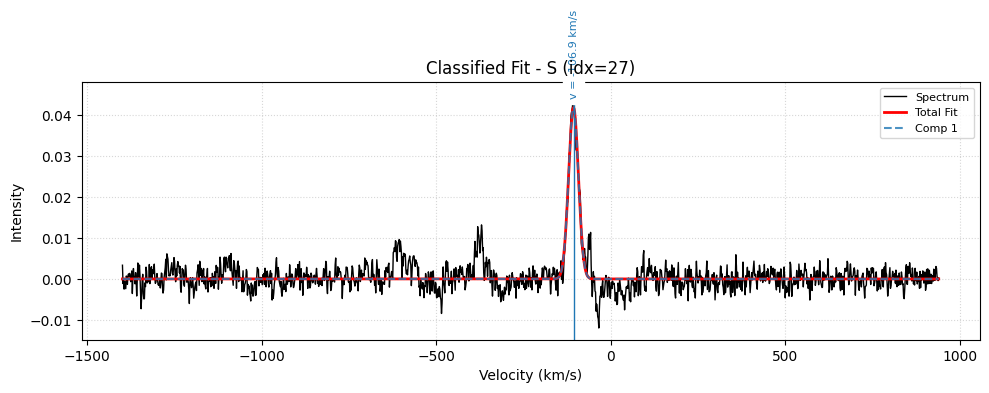

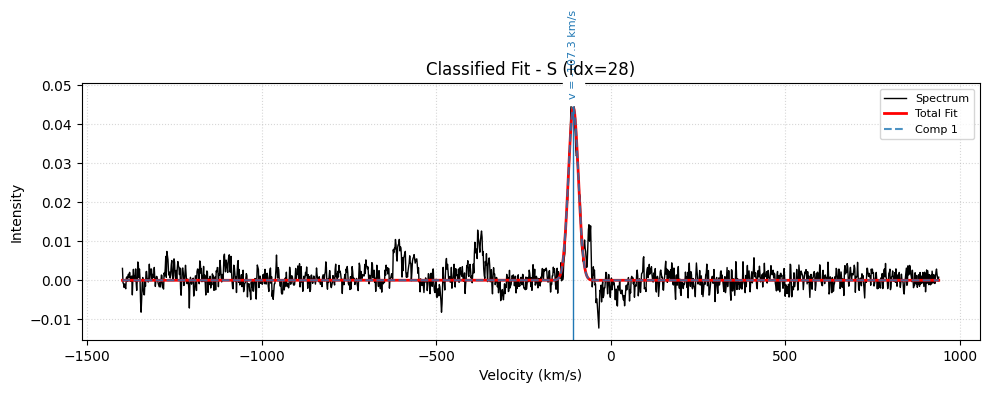

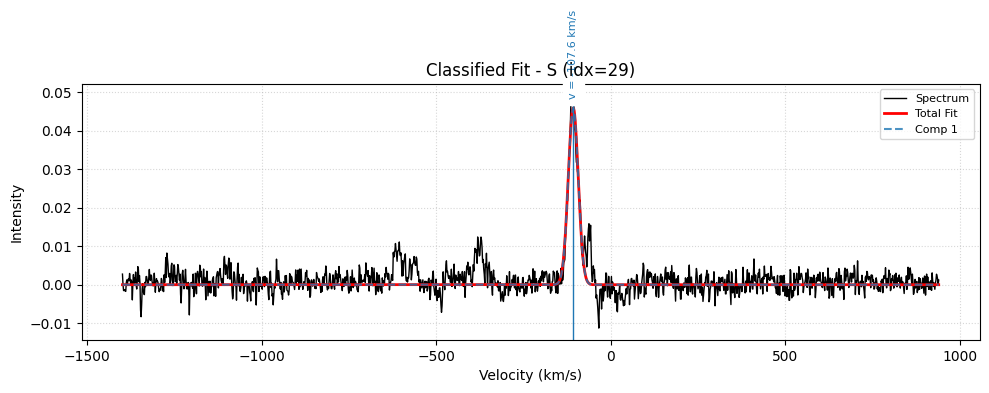

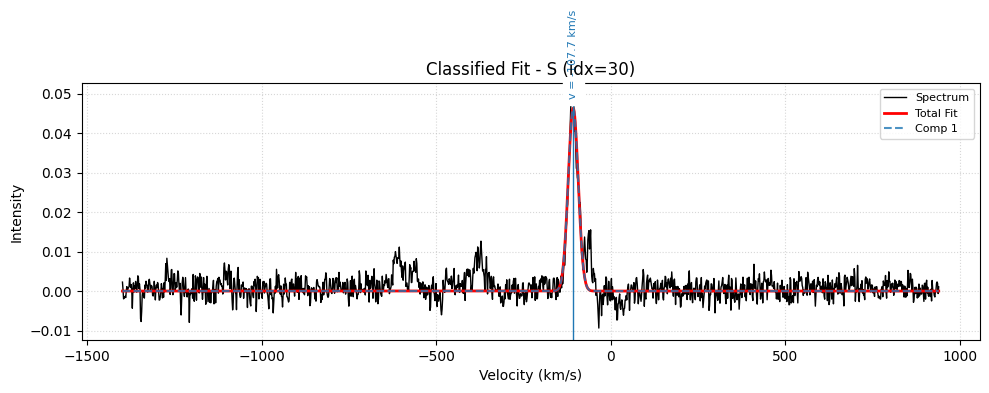

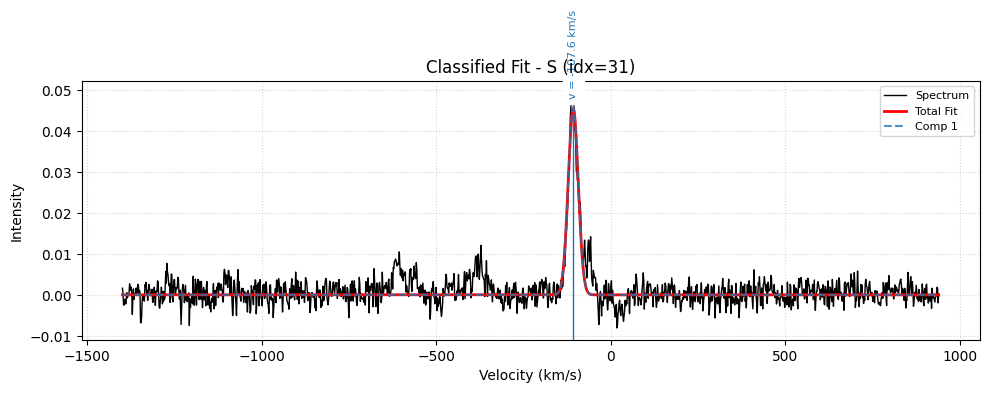

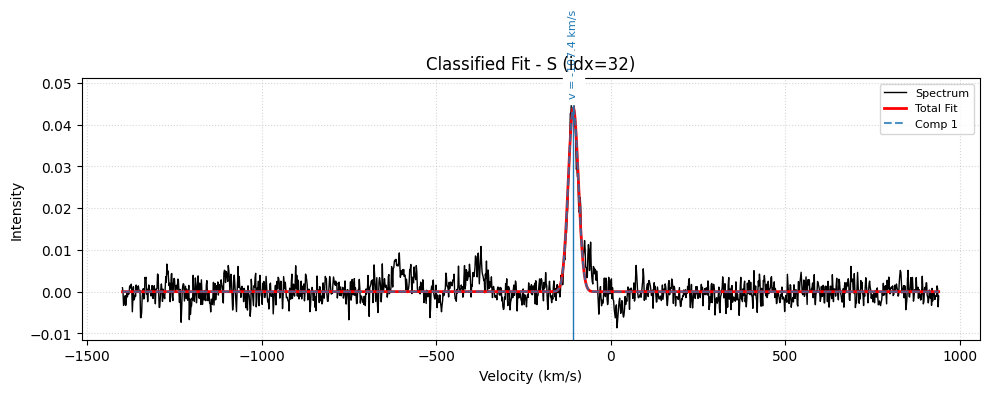

Plotted 20 spectra for category 's'.


In [29]:
# Plot the results
# 單峰
# pipeline.plot_classified_fits(fit_result_pickle='fit_result_dic.pickle', category='s', plot_max=20)
# 多峰
pipeline.plot_classified_fits(fit_result_pickle='fit_result_dic.pickle', category='s', plot_max=20)


In [30]:
# # Rest-frame (Gaussian-aligned) stacking
# v_rest, mean_rest, std_rest = pipeline.stack_restframe(plot=False)

# # Raw direct stacking
# v_raw, mean_raw, std_raw = pipeline.stack_raw_spectra(plot=False)

# # 1. Align the raw spectrum peak
# peak_idx = np.nanargmax(mean_raw)
# v_peak_raw = v_raw[peak_idx]
# v_raw_aligned = v_raw - v_peak_raw  # Align the main peak to v=0 km/s

# # 2. Set frequency (unit GHz)
# c = 299792.458
# freq_raw0 = 217.104980   # Center frequency of raw spectrum at v=0
# target_freq = 217.238530 # Frequency to be marked

# # 3. Calculate the velocity position of the frequency marker line
# v_target_raw = c * (1 - target_freq / freq_raw0)
# v_target_raw_aligned = v_target_raw - v_peak_raw

# # 4. Plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.plot(v_raw_aligned, mean_raw, label='Raw Stacked Spectrum (Aligned)', color='gray', linewidth=1.5)
# plt.plot(v_rest, mean_rest, label='Rest-frame Stacked Spectrum', color='black', linewidth=2)
# plt.axvline(0, linestyle='--', color='red', label='Aligned Main Peak (v=0 km/s)')
# plt.axvline(v_target_raw_aligned, linestyle='--', color='orange',
#             label=f'{target_freq:.3f} GHz ({v_target_raw_aligned:.1f} km/s)')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel('Stacked Intensity')
# plt.title('Raw vs. Rest-frame Stacked Spectrum (with Marked Frequency)')
# plt.legend()
# plt.grid(True, linestyle=':')
# plt.tight_layout()
# plt.xlim(-200, 200)
# plt.show()


Stacking done: 375/400 spectra used (93.8%)
Stacked 400 raw spectra.


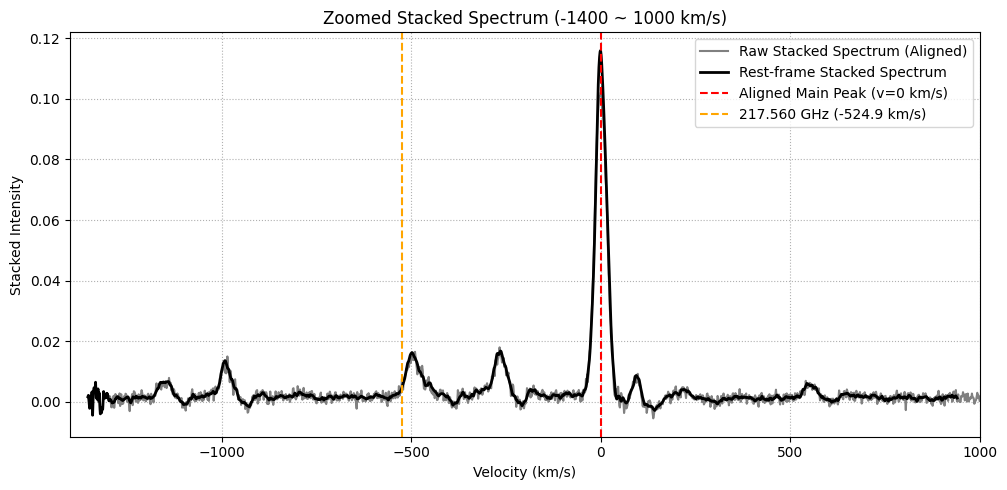

In [47]:
# 疊加
v_rest, mean_rest, std_rest = pipeline.stack_restframe(plot=False)
v_raw, mean_raw, std_raw = pipeline.stack_raw_spectra(plot=False)

pipeline.plot_stacked_zoom(
    v_rest, mean_rest,
    v_raw, mean_raw,
    target_freq= 217.56, #DCN(3-2): 217.238530
    freq_raw0=217.104980,
    vmin=-1400, vmax=1000
)